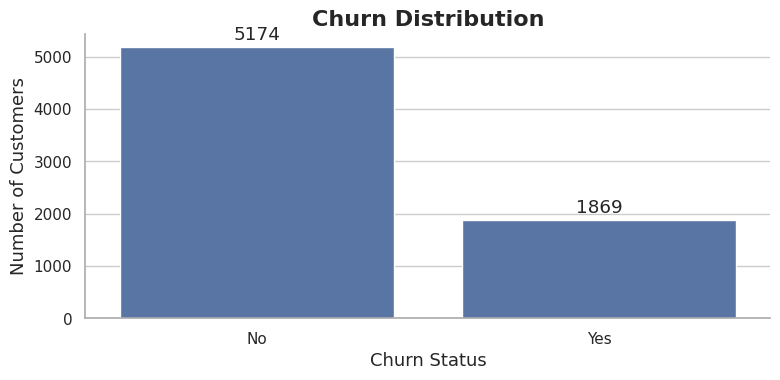

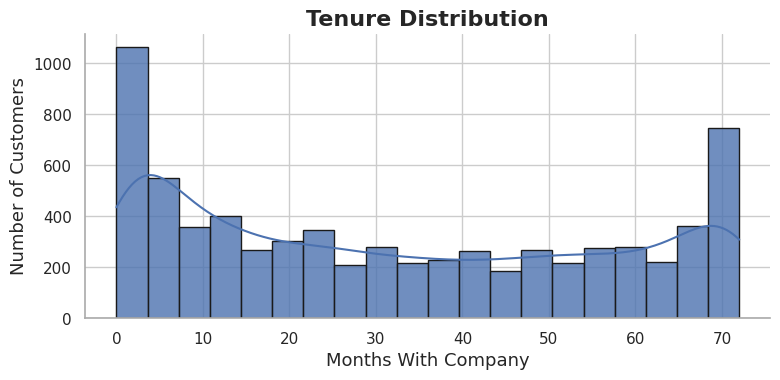

customerID         0
gender             0
SeniorCitizen      0
Partner            0
Dependents         0
tenure             0
PhoneService       0
MultipleLines      0
InternetService    0
OnlineSecurity     0
dtype: int64


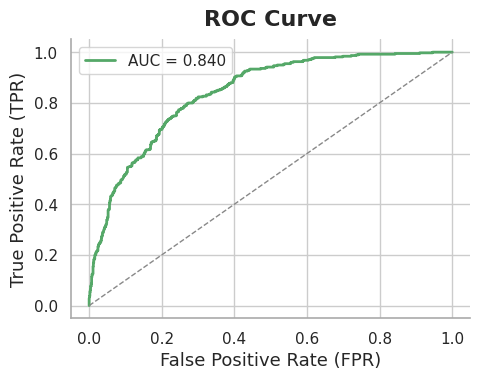

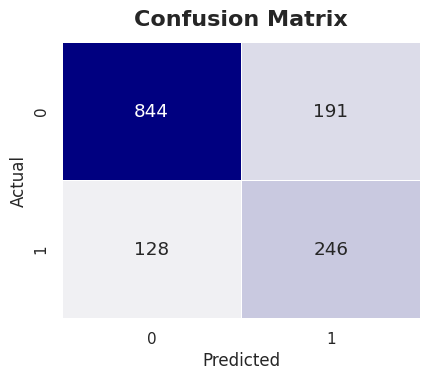

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      1035
           1       0.56      0.66      0.61       374

    accuracy                           0.77      1409
   macro avg       0.72      0.74      0.72      1409
weighted avg       0.79      0.77      0.78      1409



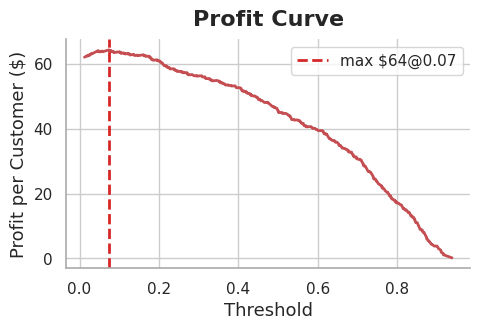

Optimal business threshold: 0.074 | Max profit: $64.26


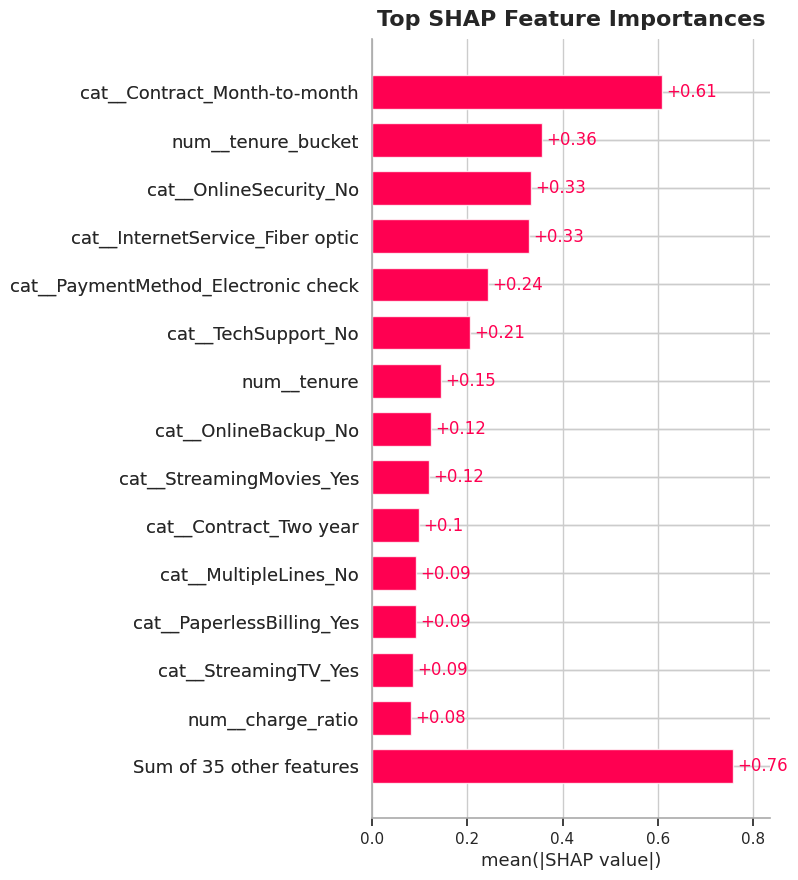

Drift check for 'MonthlyCharges': {'ks_stat': np.float64(0.030199346869231862), 'p_value': np.float64(0.7755293117796408)}


In [2]:
"""
Telco Customer Churn Early Warning Dashboard
Author: Rhishi Kumar Ayyappan

- Loads the IBM Telco-Churn dataset
- Conducts EDA with clear, modern, and colorblind-friendly visuals
- Feature engineering for deeper business insight
- Trains a robust SMOTE + GradientBoosting pipeline
- Visualizes ROC, confusion, profit, and SHAP importance using app-style plots
- Deploys as a FastAPI endpoint for real-time scoring

Instructions for use are stored in the `usage` variable at the end of the script.
"""

# ==============================
# SECTION 1: Imports & App Palette
# ==============================
import sys
!{sys.executable} -m pip install -q fastapi uvicorn imbalanced-learn shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import pickle
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import ks_2samp
from fastapi import FastAPI
from pydantic import BaseModel
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

# Set a modern, consistent, colorblind-friendly style
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 13,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'axes.titleweight': 'bold',
    'legend.fontsize': 11,
    'axes.edgecolor': '#AAAAAA',
    'axes.linewidth': 1.2
})

# ==============================
# SECTION 2: Config & Constants
# ==============================
DATA_URL = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
CLV, COST = 72, 10
RANDOM_STATE = 42
MODEL_DIR = pathlib.Path("artifacts")
MODEL_DIR.mkdir(exist_ok=True)
MODEL_PATH = MODEL_DIR / "churn_gbm.pkl"
PREP_PATH  = MODEL_DIR / "preprocessor.pkl"

# ==============================
# SECTION 3: Data Load & EDA
# ==============================
df = pd.read_csv(DATA_URL).dropna(how="all")
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# EDA: Churn Distribution
plt.figure(figsize=(8,4))
ax = sns.countplot(x="Churn", data=df)
ax.set_title("Churn Distribution")
ax.set_xlabel("Churn Status")
ax.set_ylabel("Number of Customers")
for c in ax.containers:
    ax.bar_label(c, fmt='%d', padding=3)
sns.despine()
plt.tight_layout()
plt.show()

# EDA: Tenure Distribution
plt.figure(figsize=(8,4))
ax = sns.histplot(df["tenure"], bins=20, kde=True, color=sns.color_palette()[0], edgecolor='k', alpha=0.8)
ax.set_title("Tenure Distribution")
ax.set_xlabel("Months With Company")
ax.set_ylabel("Number of Customers")
sns.despine()
plt.tight_layout()
plt.show()

# Null check
print(df.isnull().sum().sort_values(ascending=False).head(10))

# ==============================
# SECTION 4: Feature Engineering
# ==============================
df["tenure_bucket"]       = pd.cut(df["tenure"], [0,6,12,24,48,72], labels=False)
df["avg_monthly_charge"]  = df["TotalCharges"] / df["tenure"].replace(0,1)
df["charge_ratio"]        = df["MonthlyCharges"] / df["avg_monthly_charge"]
df["support_calls_ratio"] = (df["TechSupport"].map({"Yes":1,"No":0,"No internet service":0}) /
                             df["tenure"].replace(0,1))

y = df["Churn"].map({"Yes":1, "No":0})
X = df.drop(columns=["Churn", "customerID"])
num_cols = X.select_dtypes("number").columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler())
])
pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# ==============================
# SECTION 5: Train-Test Split
# ==============================
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# ==============================
# SECTION 6: ML Pipeline with SMOTE + GBM
# ==============================
pipe = ImbPipeline([
    ("prep",  pre),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("model", GradientBoostingClassifier(random_state=RANDOM_STATE))
]).fit(X_tr, y_tr)

# ==============================
# SECTION 7: Evaluation & Modern Visualizations
# ==============================
proba = pipe.predict_proba(X_te)[:,1]
preds = pipe.predict(X_te)

# ROC Curve (app style)
fpr, tpr, thr = roc_curve(y_te, proba)
roc_auc = roc_auc_score(y_te, proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color=sns.color_palette()[2], lw=2)
plt.plot([0,1], [0,1], '--', c="#888888", lw=1)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve", pad=10)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

# Confusion matrix (app style)
cm = confusion_matrix(y_te, preds)
plt.figure(figsize=(4.5,4))
cm_colors = sns.light_palette("navy", as_cmap=True)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap=cm_colors, linewidths=0.5, cbar=False)
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.set_title("Confusion Matrix", pad=12)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_te, preds))

# Profit Curve (app style)
profits = (tpr*CLV) - (fpr*COST)
best_i  = int(np.argmax(profits))
best_thr, best_profit = thr[best_i], profits[best_i]
plt.figure(figsize=(5,3.5))
plt.plot(thr, profits, color=sns.color_palette()[3], lw=2)
plt.axvline(best_thr, ls="--", color="#D62728", label=f"max ${best_profit:.0f}@{best_thr:.2f}", lw=2)
plt.xlabel("Threshold")
plt.ylabel("Profit per Customer ($)")
plt.title("Profit Curve", pad=10)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()
print(f"Optimal business threshold: {best_thr:.3f} | Max profit: ${best_profit:.2f}")

# ==============================
# SECTION 8: Explainability (SHAP, Modern Style)
# ==============================
explainer  = shap.TreeExplainer(pipe.named_steps["model"])
feature_names = pipe.named_steps["prep"].get_feature_names_out()
sample_vec = shap.sample(pipe.named_steps["prep"].transform(X_tr), 150, random_state=RANDOM_STATE)
shap_vals  = explainer(sample_vec, check_additivity=False)
shap_vals.feature_names = feature_names

import matplotlib
matplotlib.rcParams.update({'axes.prop_cycle': matplotlib.cycler(color=sns.color_palette("deep"))})
shap.plots.bar(shap_vals, max_display=15, show=False)
plt.title("Top SHAP Feature Importances", pad=10)
plt.tight_layout()
plt.show()

# Local force plot for first test sample
shap.initjs()
single_raw = X_te.iloc[[0]]
single_vec = pipe.named_steps["prep"].transform(single_raw)
local_vals = explainer(single_vec, check_additivity=False)
html = shap.force_plot(explainer.expected_value,
                       local_vals.values,
                       feature_names=feature_names,
                       matplotlib=False)
display(HTML(html.html()))

# ==============================
# SECTION 9: Drift Detection Helper
# ==============================
def ks_drift(new_df: pd.DataFrame, ref_df: pd.DataFrame, col: str):
    """Kolmogorov–Smirnov test for data drift detection on a single column."""
    stat, p = ks_2samp(ref_df[col], new_df[col])
    return {"ks_stat": stat, "p_value": p}

baseline_ref = df.sample(500, random_state=RANDOM_STATE)
print("Drift check for 'MonthlyCharges':", ks_drift(df, baseline_ref, "MonthlyCharges"))

# ==============================
# SECTION 10: Save Model & Preprocessor
# ==============================
joblib.dump(pipe.named_steps["model"], MODEL_PATH)
pickle.dump(pre, open(PREP_PATH, "wb"))

# ==============================
# SECTION 11: FastAPI Real-Time Scoring Endpoint
# ==============================
app = FastAPI(title="Churn Early-Warning API")

class Customer(BaseModel):
    payload: dict

@app.post("/score")
def score(cust: Customer):
    try:
        data = pd.DataFrame([cust.payload])
        prob = pipe.predict_proba(data)[0,1]
        return {"churn_probability": float(prob),
                "at_risk": bool(prob >= best_thr)}
    except Exception as e:
        return {"error": str(e), "churn_probability": None, "at_risk": None}

# To run locally:
# uvicorn this_script:app --reload

# ==============================
# SECTION 12: Usage & README (as variable)
# ==============================
usage = """
How to Use:
-----------
1. Run this notebook/script to train and save your churn prediction model.
2. The FastAPI endpoint can be run with:
       uvicorn this_script:app --reload
3. POST a customer JSON to /score (see below for format).
4. All artifacts are saved in ./artifacts/

Example input:
{
  "payload": {
    "gender": "Female",
    "SeniorCitizen": 0,
    ...
  }
}

Notes:
------
- All categorical values must match training data format.
- Add more error handling in production as needed.
"""

# To view the usage instructions at any time:
# print(usage)
